In [1]:
import sys
sys.path.insert(0, '../')

import data_preparation as dp
import rnn_model as rnn

import numpy as np
import pandas as pd
import tensorflow as tf
import random as rn
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from math import ceil

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [3]:
sentiment_data = dp.data_loader('../../data/stanfordSentimentTreebank/')
sentiment_data = dp.data_preprocessor(sentiment_data)

In [4]:
# Train and evaluate the model for each of the text columns
columns = ['tokenized_text', 'no_punctuation_text', 'no_stopwords_text', 'stemmed_text', 'lemmatized_text']

curr_results = []
confusion_matrices = []

# Check if the log file exists
if os.path.exists('rnn_results.csv'):
    results_log = pd.read_csv('rnn_results.csv')
else:
    results_log = pd.DataFrame(columns=['Model Structure', 'Text', 'Accuracy', 'Precision', 'Recall', 'F1'])
    results_log.to_csv('rnn_results.csv', index=False)

for column in columns:
    # Split the data into train, test and dev sets
    train_data, test_data, dev_data = dp.train_test_dev_split(sentiment_data, column)

    # Train and evaluate the model
    test_predictions, model_structure, accuracy, precision, recall, f1 = rnn.train_and_evaluate(train_data, test_data, dev_data)
    curr_results.append((accuracy, precision, recall, f1))

    # Create confusion matrix
    test_true_classes = np.argmax(test_data[1], axis=1)
    cm = confusion_matrix(test_true_classes, test_predictions)
    confusion_matrices.append((cm, column))

    # Check if the model structure and text column exist in the log
    if ((results_log['Model Structure'] == model_structure) & (results_log['Text'] == column)).any():
        # Update the existing row
        results_log.loc[(results_log['Model Structure'] == model_structure) & (results_log['Text'] == column),
                        ['Accuracy', 'Precision', 'Recall', 'F1']] = [accuracy, precision, recall, f1]
    else:
        # Append a new row
        new_row = pd.DataFrame({'Model Structure': [model_structure], 'Text': [column],
                                'Accuracy': [accuracy], 'Precision': [precision],
                                'Recall': [recall], 'F1': [f1]})
        results_log = pd.concat([results_log, new_row], ignore_index=True)
    
curr_results_df = pd.DataFrame(curr_results, columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=columns)

# Write the DataFrame back to the rnn_results.csv file
results_log.to_csv('rnn_results.csv', index=False)

Epoch 1/30
254/254 [==============================] - 37s 116ms/step - loss: 3.6235 - categorical_accuracy: 0.1970 - val_loss: 2.6924 - val_categorical_accuracy: 0.1820
Epoch 2/30
254/254 [==============================] - 29s 113ms/step - loss: 2.3671 - categorical_accuracy: 0.1864 - val_loss: 2.0892 - val_categorical_accuracy: 0.2404
Epoch 3/30
254/254 [==============================] - 28s 112ms/step - loss: 1.9476 - categorical_accuracy: 0.1833 - val_loss: 1.8308 - val_categorical_accuracy: 0.2337
Epoch 4/30
254/254 [==============================] - 28s 112ms/step - loss: 1.7687 - categorical_accuracy: 0.1662 - val_loss: 1.7176 - val_categorical_accuracy: 0.1264
Epoch 5/30
254/254 [==============================] - 29s 112ms/step - loss: 1.6908 - categorical_accuracy: 0.1694 - val_loss: 1.6690 - val_categorical_accuracy: 0.1264
Epoch 6/30
254/254 [==============================] - 29s 112ms/step - loss: 1.6564 - categorical_accuracy: 0.1518 - val_loss: 1.6498 - val_categorical_acc

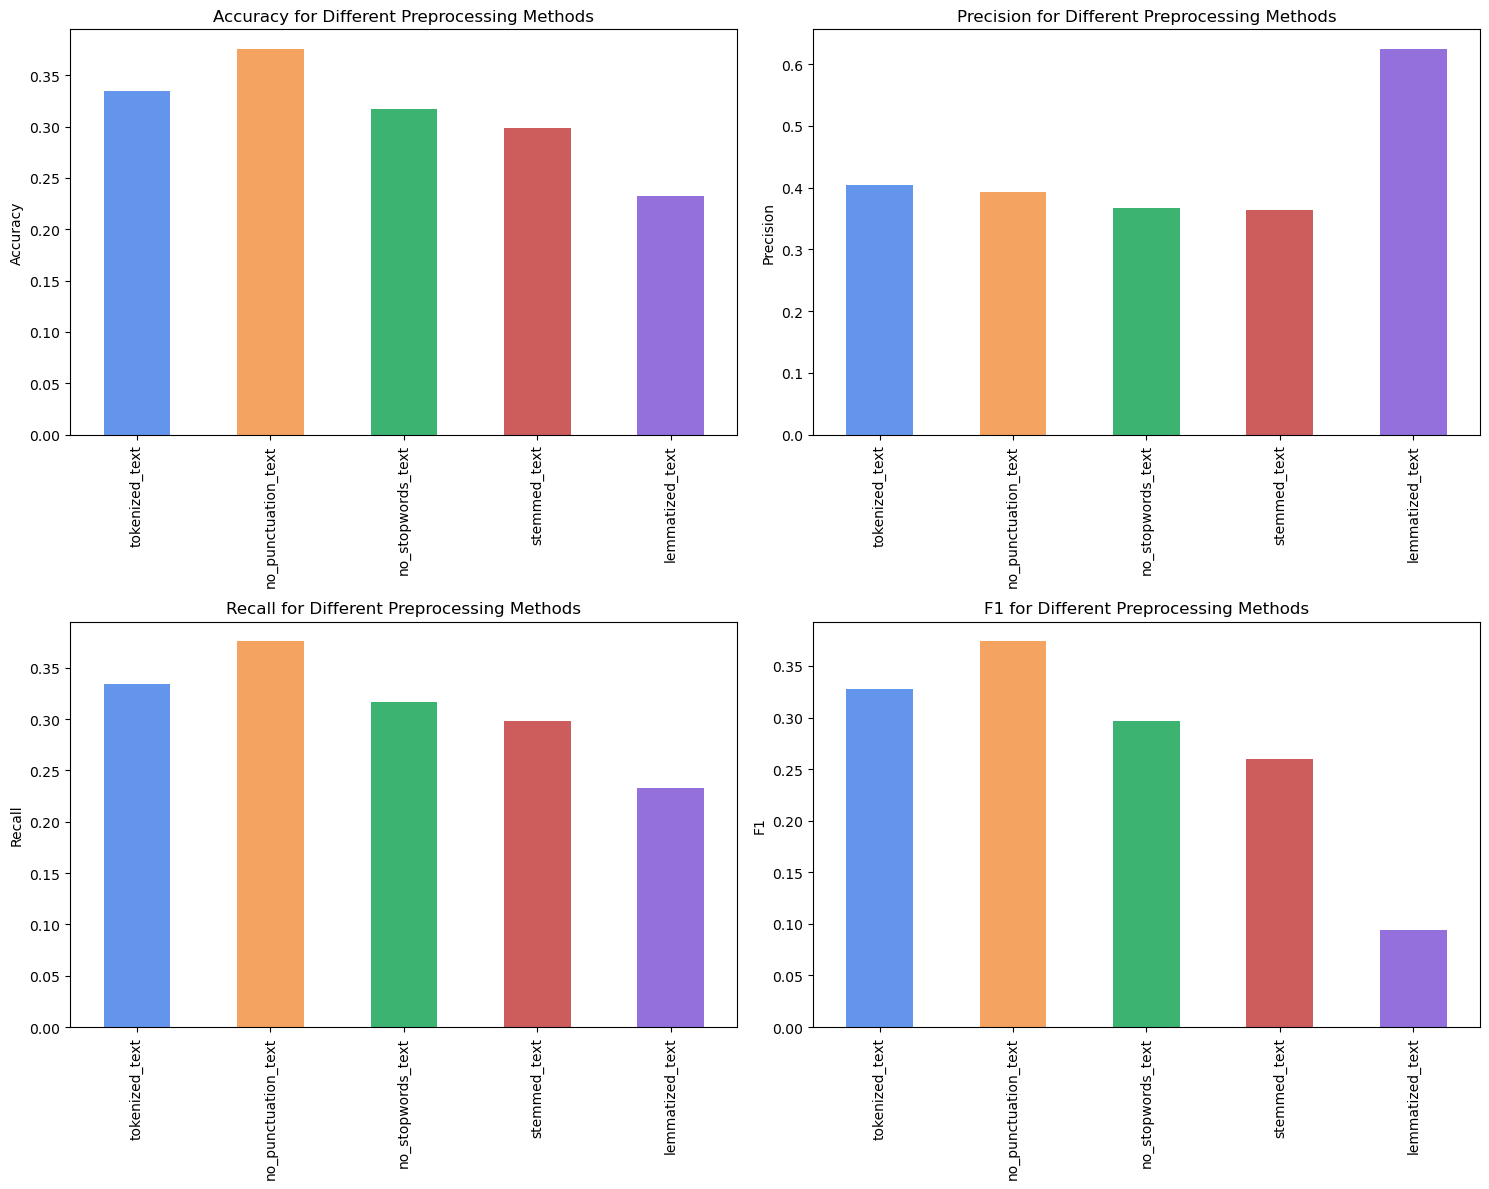

In [5]:
# Create a list of colors
colors = ['cornflowerblue', 'sandybrown', 'mediumseagreen', 'indianred', 'mediumpurple']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Plot Accuracy
curr_results_df['Accuracy'].plot(kind='bar', ax=axes[0, 0], color=colors)
axes[0, 0].set_title('Accuracy for Different Preprocessing Methods')
axes[0, 0].set_ylabel('Accuracy')

# Plot Precision
curr_results_df['Precision'].plot(kind='bar', ax=axes[0, 1], color=colors)
axes[0, 1].set_title('Precision for Different Preprocessing Methods')
axes[0, 1].set_ylabel('Precision')

# Plot Recall
curr_results_df['Recall'].plot(kind='bar', ax=axes[1, 0], color=colors)
axes[1, 0].set_title('Recall for Different Preprocessing Methods')
axes[1, 0].set_ylabel('Recall')

# Plot F1
curr_results_df['F1'].plot(kind='bar', ax=axes[1, 1], color=colors)
axes[1, 1].set_title('F1 for Different Preprocessing Methods')
axes[1, 1].set_ylabel('F1')

plt.tight_layout()
plt.show()

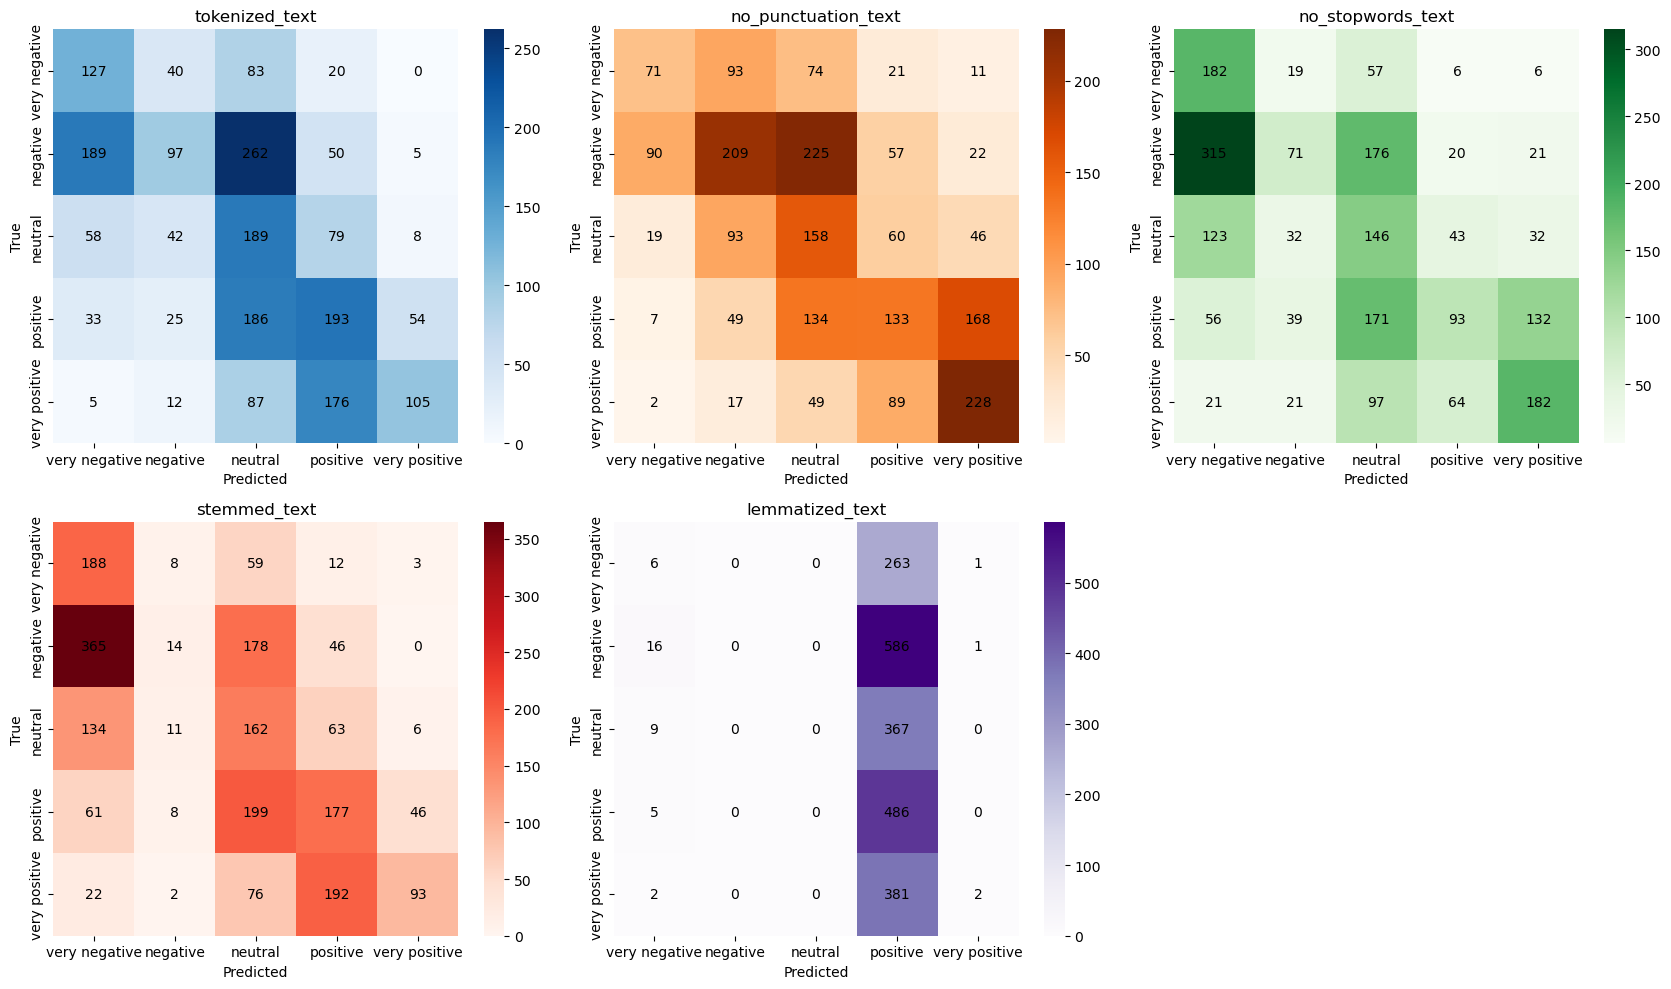

In [6]:
# Define a list of color maps
cmaps = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples']

# Define the labels
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']

# Calculate the number of rows and columns for subplots
n = len(confusion_matrices)
ncols = ceil(n / 2)
nrows = 2 if n > ncols else 1

# Plot confusion matrices
fig, axs = plt.subplots(nrows, ncols, figsize=(17, 10))
axs = axs.flatten()
for i, (cm, column) in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=False, fmt='d', cmap=cmaps[i % len(cmaps)], ax=axs[i])
    axs[i].set_title(column)
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('True')
    axs[i].set_xticklabels(labels)
    axs[i].set_yticklabels(labels)

    # Manually add annotations TODO: Figure out why annot=True doesn't work
    for j in range(cm.shape[0]):
        for k in range(cm.shape[1]):
            axs[i].text(k+0.5, j+0.5, cm[j, k], ha='center', va='center')

# Remove any unused subplots
if n < len(axs):
    for ax in axs[n:]:
        ax.remove()

plt.tight_layout()
plt.show()